# Νευρωνικά Δίκτυα

Παρακάτω θα παρουσιάσουμε μερικές αρχιτεκτονικές νευρωνικών δικτύων.

***

## Συναρτήσεις 

Οι παρακάτω βοηθητικές συναρτήσεις θα χρησιμοποιηθούν για να κάνουμε train και test το μοντέλο.

Αρχικά κάνουμε τα απαραίτητα imports και ορίζουμε την συσκευή που θα χρησιμοποιήσουμε (cpu/gpu).

In [102]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
import pandas as pd

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device, imports complete!'.format(device))

Using cuda device, imports complete!


Στην συνέχεια ορίζουμε την πρώτη συνάρτηση η οποία δέχεται ένα μοντέλο, το training dataset, την συνάρτηση λάθους, τον optimizer, και την συσκευή που χρησιμοποιούμε. Προχωράει το training κατά ένα βήμα και επιστρέφει την απώλεια.

In [2]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = 'cpu'):
    model.to(device)
    model.train()

    train_loss = 0
    for X_batch, y_batch in data_loader:
        # Send data to GPU
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        y_pred = model(X_batch)

        # Compute loss
        loss = loss_fn(y_pred, y_batch)

        # Zero gradients
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update the weights
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping to prevent gradients exploding
        optimizer.step()

        train_loss += loss.item()
    
    return train_loss


Ομοίως η παρακάτω συνάρτηση κάνει test το μοντέλο σε κάθε εποχή, και επιστρέφει την απώλεια.

In [3]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device = 'cpu'):
    model.to(device)
    model.eval()

    test_loss = 0
    with torch.inference_mode():
        for X_batch, y_batch in data_loader:
            # Send data to GPU
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_test_pred = model(X_batch)
            test_loss += loss_fn(y_test_pred, y_batch).item()
    
    return test_loss

Η βασική συνάρτηση, επαναληπτικά για όσες εποχές έχουμε διαλέξει κάνει train και test το μοντέλο, και ανά 10 εποχές εκτυπώνει τα αποτελέσματα. Επιστρέφει 2 πίνακες με τις συνολικές απώλειες σε κάθε επανάληψη.

In [4]:
def train_test_model(epoch : int, 
                     model: torch.nn.Module,
                     train_loader: torch.utils.data.DataLoader,
                     test_loader: torch.utils.data.DataLoader,
                     loss_fn: torch.nn.Module,
                     optimizer: torch.optim.Optimizer,
                     scheduler,
                     device: torch.device = 'cpu'):
    torch.manual_seed(42)
    train_loss_arr = []
    test_loss_arr = []
    for epochs in range(epoch):
        epoch_loss = train_step(model, train_loader, loss_fn, optimizer, device)
        train_loss_arr.append(epoch_loss / len(train_loader))

        scheduler.step(epoch_loss)
        after_lr = optimizer.param_groups[0]['lr']

        test_loss = test_step(model, test_loader, loss_fn, device)
        test_loss_arr.append(test_loss / len(test_loader))

        if (epochs) % 10 == 0 or epochs == 0:
            print(f'Epoch {epochs} | Loss train: {train_loss_arr[-1]} | Loss test: {test_loss_arr[-1]} | lr = {after_lr}')
        elif epochs + 1 == epoch:
            print(f'Epoch {epoch} | Loss train: {train_loss_arr[-1]} | Loss test: {test_loss_arr[-1]} | lr = {after_lr}')
    
    return train_loss_arr, test_loss_arr

Η συνάρτηση είναι παρόμοια με την test_step με την διαφορά ότι επιστρέφει ένα dictionary με τα βασικά στοιχεία του μοντέλου.

In [5]:
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               device: torch.device = 'cpu'):
    loss = 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
        loss /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item()
            }

Η συνάρτηση αυτή χρησιμοποιείται για να εμφανίσει τις κανονικοποιημένες στο (0,1) train_loss και test_loss curves.

In [17]:
def plot_results(train_arr, test_arr):
    # Plot the loss curves
    train_arr = (train_arr - np.min(train_arr)) / (np.max(train_arr) - np.min(train_arr))
    test_arr = (test_arr - np.min(test_arr)) / (np.max(test_arr) - np.min(test_arr))
    
    plt.figure(figsize=(8, 5))
    plt.plot(train_arr, label='Train Loss')
    plt.plot(test_arr, label='Test Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Normalized Loss")
    plt.title("Normalized Training Loss")
    plt.grid()
    plt.legend()
    plt.show()

***

## Εισαγωγή δεδομένων

Η συνάρτηση αυτή δέχεται τα paths των δεδομένων, δημιουργεί και επιστρέφει τα mini_batches που θα χρησιμοποιηθούν στο training.

In [12]:
def data_func(input_path, labels_path, batch_size = 32, test_size = 0.2):
    input_array = np.load(input_path)
    labels = np.load(labels_path)

    # Reshape the tensor to 2D so that it can be used in the linear model
    X = input_array.reshape(len(input_array), -1)
    y = labels

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    scaler = StandardScaler()
    # Fit the scaler on the training data and transform both the training and test sets
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Transform the data to PyTorch tensors and move them to the GPU if available
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    # Define the dataset
    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    test_data = TensorDataset(X_test_tensor, y_test_tensor)

    # Define the data loader
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True) 
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size)

    return train_loader, test_loader

***

## Αρχιτεκτονικές

### Αρχιτεκτονική 1

Το πρώτο μας μοντέλο θα είναι η απλούστερη περίπτωση ενός γραμμικού layer με είσοδο το ```input_size``` δηλαδή 4000 (για την ώρα) , και έξοδο 2 (x,y), χωρίς για αρχή κάποια συνάρτηση ενεργοποίησης.

Σαν συνάρτηση λάθους θα χρησιμοποιηθεί η ```MSELoss``` ενώ σαν optimizers θα δοκιμαστούν οι ```Adam```, ```RMSProp```, ```SGD```.

In [9]:
class SimpleModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= output_size),  
        )
    
    def forward(self, x):
        return self.linear_stack(x)

In [39]:
input_len = 4000
output_len = 2

# Instantiate the model
model_0 = SimpleModel(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=learning_rate)

# Initialize the scheduler
from torch.optim import lr_scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

model_0

SimpleModel(
  (linear_stack): Sequential(
    (0): Linear(in_features=4000, out_features=2, bias=True)
  )
)

Epoch 0 | Loss train: 8.260976016044618 | Loss test: 1.9291165955364704 | lr = 0.01
Epoch 10 | Loss train: 1.1633962219953538 | Loss test: 1.1881185583770275 | lr = 0.01
Epoch 20 | Loss train: 1.4854888025522233 | Loss test: 2.318772204220295 | lr = 0.01
Epoch 30 | Loss train: 1.2926025515198707 | Loss test: 0.9420350445434451 | lr = 0.01
Epoch 40 | Loss train: 0.11947511345148086 | Loss test: 0.17306376830674708 | lr = 0.001
Epoch 50 | Loss train: 0.1225379776954651 | Loss test: 0.1781671461649239 | lr = 0.001
Epoch 60 | Loss train: 0.08644110903143883 | Loss test: 0.09367827721871436 | lr = 0.0001
Epoch 70 | Loss train: 0.08488346838951111 | Loss test: 0.08443990163505077 | lr = 0.0001
Epoch 80 | Loss train: 0.08489119285345077 | Loss test: 0.0880862099584192 | lr = 0.0001
Epoch 90 | Loss train: 0.08095094844698907 | Loss test: 0.08461254357825965 | lr = 1e-05
Epoch 100 | Loss train: 0.08086317032575607 | Loss test: 0.0837151218438521 | lr = 1e-05


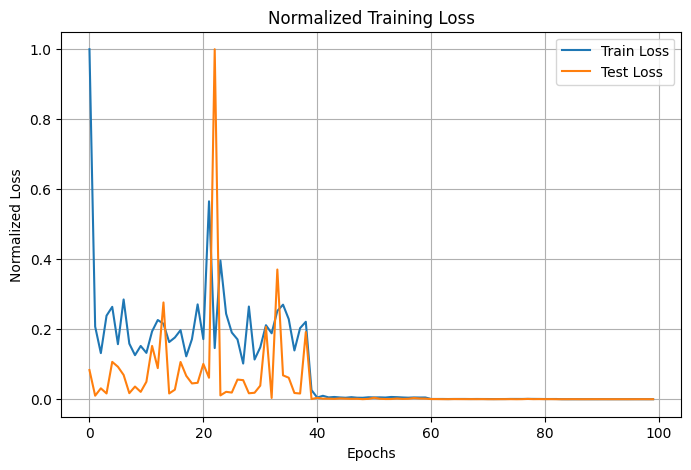

In [ ]:
train_loader, test_loader = data_func('Data.npy', 'Labels.npy')

arr1, arr2 = train_test_model(epoch = 100,model = model_0, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

Χρησιμοποιήσαμε τον optimizer ``` Adam ``` τώρα θα χρησιμοποιήσουμε τον ``` RMSProp```

In [37]:
input_len = 4000
output_len = 2

# Instantiate the model
model_1 = SimpleModel(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.RMSprop(model_1.parameters(), lr=learning_rate)

# Initialize the scheduler
from torch.optim import lr_scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

model_1

SimpleModel(
  (linear_stack): Sequential(
    (0): Linear(in_features=4000, out_features=2, bias=True)
  )
)

Epoch 0 | Loss train: 421.4349931678772 | Loss test: 82.84522199630737 | lr = 0.01
Epoch 10 | Loss train: 51.984792404174804 | Loss test: 60.260358452796936 | lr = 0.01
Epoch 20 | Loss train: 0.6170363647937774 | Loss test: 0.7331775240600109 | lr = 0.001
Epoch 30 | Loss train: 0.6129253306388855 | Loss test: 0.544620469212532 | lr = 0.001
Epoch 40 | Loss train: 0.0990700061917305 | Loss test: 0.09809663542546332 | lr = 0.0001
Epoch 50 | Loss train: 0.09543519353866577 | Loss test: 0.10642987629398704 | lr = 0.0001
Epoch 60 | Loss train: 0.09595390832424164 | Loss test: 0.09368069865740836 | lr = 1e-05
Epoch 70 | Loss train: 0.08655375498533249 | Loss test: 0.08938598202075809 | lr = 1e-05
Epoch 80 | Loss train: 0.08561851701140404 | Loss test: 0.08860959450248629 | lr = 1.0000000000000002e-06
Epoch 90 | Loss train: 0.08564513859152793 | Loss test: 0.08866932755336165 | lr = 1.0000000000000002e-06
Epoch 100 | Loss train: 0.0856402350962162 | Loss test: 0.08859240671154112 | lr = 1.0000

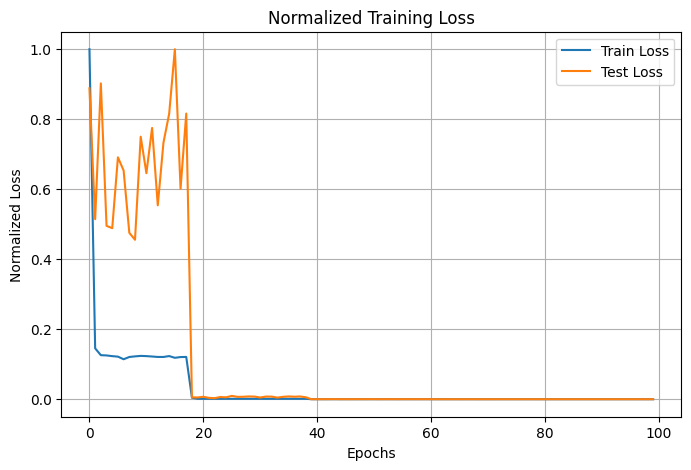

In [ ]:
train_loader, test_loader = data_func('Data.npy', 'Labels.npy')

arr1, arr2 = train_test_model(epoch = 100,model = model_1, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

Και τέλος χρησιμοποιούμε και τον ``` SGD ```

In [35]:
input_len = 4000
output_len = 2

# Instantiate the model
model_2 = SimpleModel(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=learning_rate, momentum= 0.9)

# Initialize the scheduler
from torch.optim import lr_scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

model_2

SimpleModel(
  (linear_stack): Sequential(
    (0): Linear(in_features=4000, out_features=2, bias=True)
  )
)

Epoch 0 | Loss train: 1.1352920460700988 | Loss test: 0.5348269687965512 | lr = 0.01
Epoch 10 | Loss train: 0.16690839007496833 | Loss test: 0.28568802028894424 | lr = 0.01
Epoch 20 | Loss train: 0.09016815665364265 | Loss test: 0.12837847555056214 | lr = 0.001
Epoch 30 | Loss train: 0.09419006696343422 | Loss test: 0.09772504237480462 | lr = 0.001
Epoch 40 | Loss train: 0.08427565217018128 | Loss test: 0.0883246409939602 | lr = 0.0001
Epoch 50 | Loss train: 0.08488083758950234 | Loss test: 0.08737920434214175 | lr = 0.0001
Epoch 60 | Loss train: 0.08374972018599511 | Loss test: 0.086884681484662 | lr = 1e-05
Epoch 70 | Loss train: 0.08376120236515999 | Loss test: 0.08685139275621623 | lr = 1e-05
Epoch 80 | Loss train: 0.08366441994905471 | Loss test: 0.08687334205023944 | lr = 1.0000000000000002e-06
Epoch 90 | Loss train: 0.08366227996349335 | Loss test: 0.08688706264365464 | lr = 1.0000000000000002e-06
Epoch 100 | Loss train: 0.08365033420920372 | Loss test: 0.08690353366546333 | lr 

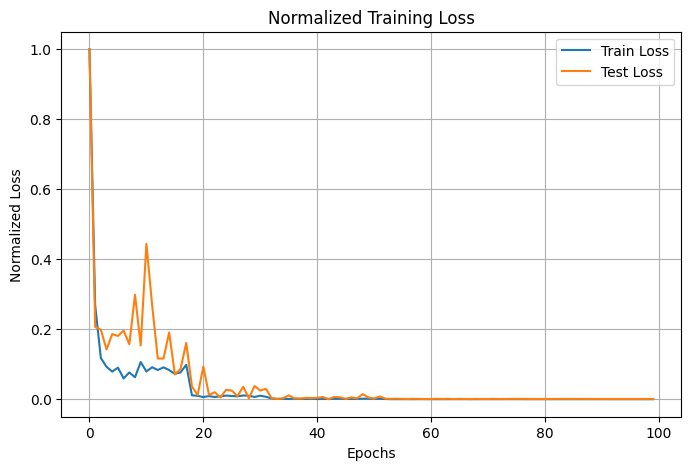

In [ ]:
train_loader, test_loader = data_func('Data.npy', 'Labels.npy')

arr1, arr2 = train_test_model(epoch = 100,model = model_2, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

Έχοντας προπονήσει τα μοντέλα για 100 εποχές με διαφορετικούς optimizers παρατηρούμε ότι η καλύτερη απόδοση έιναι από τον ``` Adam ``` ο οποίος θα χρησιμοποιηθεί και μετέπειτα.

***

### Αρχιτεκτονική 2

#### ReLU 128

Το δεύτερο μοντέλο μας θα αποκτήσει άλλα 2 layers δίνοντας μας την δυνατότητα θεωρητικά να πετύχουμε μικρότερη απώλεια συγκριτικά με την απλούστερη περίπτωση. Επιπλέον μας δίνεται η δυνατότητα να μεταβάλλουμε τόσο την μεταβλητή ```hidden_units``` που καθορίζει το μέγεθος των ενδιάμεσων επιπέδων, όσο και τις συναρτήσεις ενεργοποίησης.

Για αρχή επιλέγουμε την συνηθέστερη επιλογή την συνάρτηση ``` ReLU```, ο τύπος της οποίας δίνεται παρακάτω.

$ReLU(x) = max(0,x)$

In [71]:
from torch import nn

# Build the model

class ReLUModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 128):
        super(ReLUModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.ReLU(),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.ReLU(),
            nn.Linear(in_features= hidden_units, out_features= output_size),   
        )
    
    def forward(self, x):
        return self.linear_stack(x)

In [72]:
input_len = 4000
output_len = 2

# Instantiate the model
model_3 = ReLUModel(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=learning_rate)

# Initialize the scheduler
from torch.optim import lr_scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

model_3

ReLUModel(
  (linear_stack): Sequential(
    (0): Linear(in_features=4000, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)

Epoch 0 | Loss train: 5.465094500303269 | Loss test: 0.5506083304062486 | lr = 0.01
Epoch 10 | Loss train: 0.15092052185535432 | Loss test: 0.11315372330136597 | lr = 0.01
Epoch 20 | Loss train: 1.1620537614822388 | Loss test: 0.5604129955172539 | lr = 0.01
Epoch 30 | Loss train: 0.07686067774891853 | Loss test: 0.05239779711700976 | lr = 0.01
Epoch 40 | Loss train: 0.04121354132145643 | Loss test: 0.028754963830579072 | lr = 0.01
Epoch 50 | Loss train: 0.0450514253526926 | Loss test: 0.06374175247037783 | lr = 0.01
Epoch 60 | Loss train: 0.06952508236467839 | Loss test: 0.0380124842049554 | lr = 0.01
Epoch 70 | Loss train: 0.00784015418216586 | Loss test: 0.007077033355017193 | lr = 0.001
Epoch 80 | Loss train: 0.004566741747781634 | Loss test: 0.004360572420409881 | lr = 0.001
Epoch 90 | Loss train: 0.003221628594212234 | Loss test: 0.0036318703496363014 | lr = 0.001
Epoch 100 | Loss train: 0.003065888370387256 | Loss test: 0.0022693470600643195 | lr = 0.001


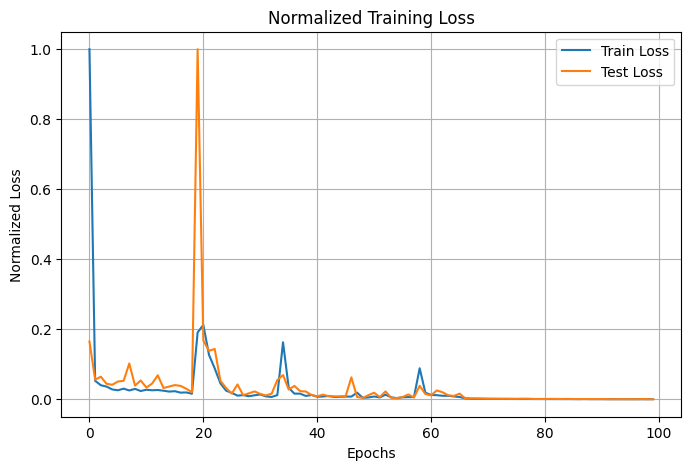

In [73]:
train_loader, test_loader = data_func('Data.npy', 'Labels.npy')

arr1, arr2 = train_test_model(epoch = 100,model = model_3, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

relu_model = eval_model(model_3, test_loader, loss_fn, device)

In [74]:
relu_model

{'model_name': 'ReLUModel', 'model_loss': 0.002269347198307514}

Ήδη τα αποτελέσματα είναι πολύ καλύτερα συγκριτικά με την προηγούμενη αρχιτεκτονική.

#### ReLU 256

Τώρα θα αυξήσουμε τον αριθμό των ```hidden_units```  από 128 σε 256 για να δούμε κάποια πιθανή διαφορά.

In [75]:
input_len = 4000
output_len = 2

# Instantiate the model
model_4 = ReLUModel(input_size=input_len, output_size=output_len, hidden_units= 256)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_4.parameters(), lr=learning_rate)

# Initialize the scheduler
from torch.optim import lr_scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

model_4

ReLUModel(
  (linear_stack): Sequential(
    (0): Linear(in_features=4000, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=2, bias=True)
  )
)

Epoch 0 | Loss train: 32.524274733781816 | Loss test: 0.42252190969884396 | lr = 0.01
Epoch 10 | Loss train: 0.15551290440559387 | Loss test: 0.15625181957148015 | lr = 0.01
Epoch 20 | Loss train: 0.8617742040157318 | Loss test: 0.6309380559250712 | lr = 0.01
Epoch 30 | Loss train: 0.2348530085682869 | Loss test: 0.20840142923407257 | lr = 0.001
Epoch 40 | Loss train: 0.11073365890979767 | Loss test: 0.09470807830803096 | lr = 0.001
Epoch 50 | Loss train: 0.1025685413479805 | Loss test: 0.08839049469679594 | lr = 0.001
Epoch 60 | Loss train: 0.058662110149860384 | Loss test: 0.0478295442298986 | lr = 0.001
Epoch 70 | Loss train: 0.02691089690104127 | Loss test: 0.08325934421736747 | lr = 0.001
Epoch 80 | Loss train: 0.024597152549773453 | Loss test: 0.033790755085647106 | lr = 0.001
Epoch 90 | Loss train: 0.016829114086925983 | Loss test: 0.011764066424802877 | lr = 0.001
Epoch 100 | Loss train: 0.0177066419608891 | Loss test: 0.019553569494746625 | lr = 0.001


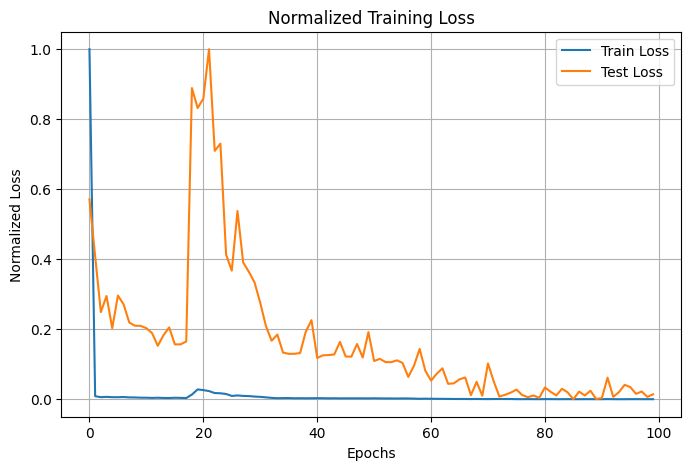

In [76]:
train_loader, test_loader = data_func('Data.npy', 'Labels.npy')

arr1, arr2 = train_test_model(epoch = 100,model = model_4, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

relu_model_256 = eval_model(model_4, test_loader, loss_fn, device)

In [77]:
relu_model_256, relu_model

({'model_name': 'ReLUModel', 'model_loss': 0.019553570076823235},
 {'model_name': 'ReLUModel', 'model_loss': 0.002269347198307514})

#### ReLU 64

Τα αποτελέσματα με 128 hidden units είναι σαφώς καλύτερα, δοκιμάζουμε τέλος με 64.

In [78]:
input_len = 4000
output_len = 2

# Instantiate the model
model_5 = ReLUModel(input_size=input_len, output_size=output_len, hidden_units= 64)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_5.parameters(), lr=learning_rate)

# Initialize the scheduler
from torch.optim import lr_scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

model_5

ReLUModel(
  (linear_stack): Sequential(
    (0): Linear(in_features=4000, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
)

Epoch 0 | Loss train: 2.074717505455017 | Loss test: 0.24404863500967622 | lr = 0.01
Epoch 10 | Loss train: 0.016616015687584876 | Loss test: 0.02927725185872987 | lr = 0.01
Epoch 20 | Loss train: 0.047325240634381774 | Loss test: 0.021831739955814555 | lr = 0.01
Epoch 30 | Loss train: 0.008356558732688427 | Loss test: 0.006413827752112411 | lr = 0.001
Epoch 40 | Loss train: 0.0062346196305006745 | Loss test: 0.006944943088456057 | lr = 0.001
Epoch 50 | Loss train: 0.004828410439193249 | Loss test: 0.0039791191593394615 | lr = 0.001
Epoch 60 | Loss train: 0.0035558763686567543 | Loss test: 0.004193321947241202 | lr = 0.001
Epoch 70 | Loss train: 0.002658014633692801 | Loss test: 0.0030062352307140827 | lr = 0.001
Epoch 80 | Loss train: 0.002184320188127458 | Loss test: 0.0020818498014705256 | lr = 0.001
Epoch 90 | Loss train: 0.0022400545054115355 | Loss test: 0.003032886204891838 | lr = 0.001
Epoch 100 | Loss train: 0.002037340919021517 | Loss test: 0.0046988531612441875 | lr = 0.001


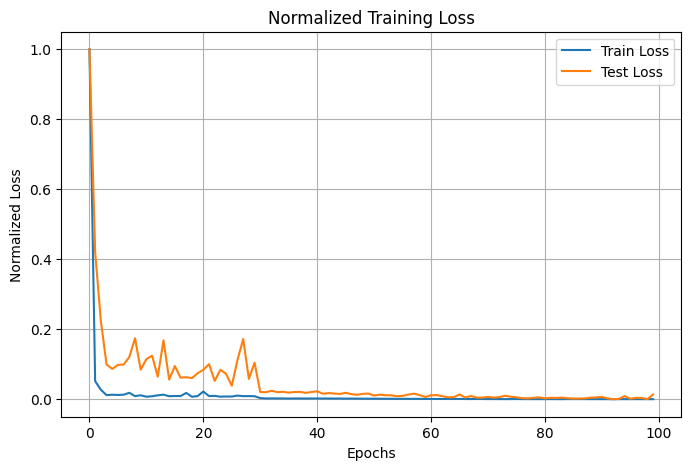

In [79]:
train_loader, test_loader = data_func('Data.npy', 'Labels.npy')

arr1, arr2 = train_test_model(epoch = 100,model = model_5, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

relu_model_64 = eval_model(model_5, test_loader, loss_fn, device)

In [80]:
relu_model_256, relu_model_64, relu_model

({'model_name': 'ReLUModel', 'model_loss': 0.019553570076823235},
 {'model_name': 'ReLUModel', 'model_loss': 0.004698853008449078},
 {'model_name': 'ReLUModel', 'model_loss': 0.002269347198307514})

Η καλύτερη περίπτωση φαίνεται να είναι με 128 ```hidden_units```

***

### Αρχιτεκτονική 2.1

#### LeakyRELU

Για την συγκεκριμένη αρχιτεκτονική και τα συγκεκριμένα ```hidden_units``` θα μελετήσουμε την διαφορά που προκαλούν διάφορες συναρτήσεις ενεργοποίησης.

Αρχικά μελετάμε την LeakyReLU, με τύπο:

$LeakyReLU(x) = max(0,x) + negative\_slope * min(0,x)$

In [93]:
class LeakyReLUModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 128):
        super(LeakyReLUModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= output_size),   
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 6.163294807910919 | Loss test: 0.3722965298220515 | lr = 0.01
Epoch 10 | Loss train: 0.04973378100246191 | Loss test: 0.08963118260726333 | lr = 0.01
Epoch 20 | Loss train: 0.10776020107418299 | Loss test: 0.03414365078788251 | lr = 0.01
Epoch 30 | Loss train: 0.005787418164312839 | Loss test: 0.0037997244580765255 | lr = 0.001
Epoch 40 | Loss train: 0.0025751694170758127 | Loss test: 0.0027274500716885086 | lr = 0.001
Epoch 50 | Loss train: 0.0023374674855731426 | Loss test: 0.0018477038793207612 | lr = 0.001
Epoch 60 | Loss train: 0.0014146194206550717 | Loss test: 0.001508054010628257 | lr = 0.001
Epoch 70 | Loss train: 0.0013706477517262102 | Loss test: 0.0014937039741198532 | lr = 0.001
Epoch 80 | Loss train: 0.0012888000281527639 | Loss test: 0.0008714337600395083 | lr = 0.001
Epoch 90 | Loss train: 0.0013232352200429887 | Loss test: 0.0008632655080873519 | lr = 0.001
Epoch 100 | Loss train: 0.00023298583267023786 | Loss test: 0.00021841860325366724 | lr = 0

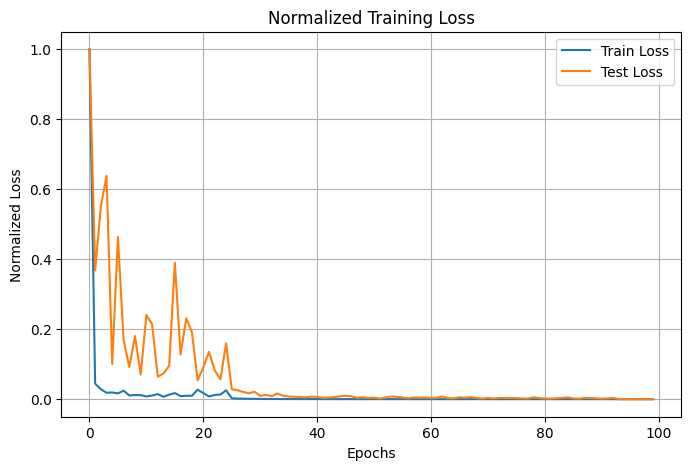

In [94]:
input_len = 4000
output_len = 2

# Instantiate the model
model_6 = LeakyReLUModel(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_6.parameters(), lr=learning_rate)

# Initialize the scheduler
from torch.optim import lr_scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Load the data
arr1, arr2 = train_test_model(epoch = 100,model = model_6, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

leakyrelu = eval_model(model_6, test_loader, loss_fn, device)

#### Tanh

Δοκιμάζουμε την συνάρτηση ενεργοποίησης tanh. 

$tanh(x) = \frac{exp(x) - exp(-x)}{exp(x) + exp(-x)}$

In [96]:
class tanhModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 128):
        super(tanhModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.Tanh(),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.Tanh(),
            nn.Linear(in_features= hidden_units, out_features= output_size),   
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 0.6142509934902192 | Loss test: 0.3799808034673333 | lr = 0.01
Epoch 10 | Loss train: 0.19628088492155074 | Loss test: 0.17452436219900846 | lr = 0.01
Epoch 20 | Loss train: 0.20922339308261872 | Loss test: 0.27166280010715127 | lr = 0.01
Epoch 30 | Loss train: 0.12574435555934907 | Loss test: 0.1320085923653096 | lr = 0.001
Epoch 40 | Loss train: 0.11185575765371322 | Loss test: 0.12091964366845787 | lr = 0.001
Epoch 50 | Loss train: 0.10175832450389861 | Loss test: 0.12187987030483782 | lr = 0.001
Epoch 60 | Loss train: 0.09611642220616341 | Loss test: 0.10949716554023325 | lr = 0.001
Epoch 70 | Loss train: 0.0931337119936943 | Loss test: 0.10720707383006811 | lr = 0.001
Epoch 80 | Loss train: 0.09296169555187225 | Loss test: 0.11803998262621462 | lr = 0.001
Epoch 90 | Loss train: 0.09283825951814652 | Loss test: 0.11076818802393973 | lr = 0.001
Epoch 100 | Loss train: 0.09219076004624367 | Loss test: 0.11002902290783823 | lr = 0.0001


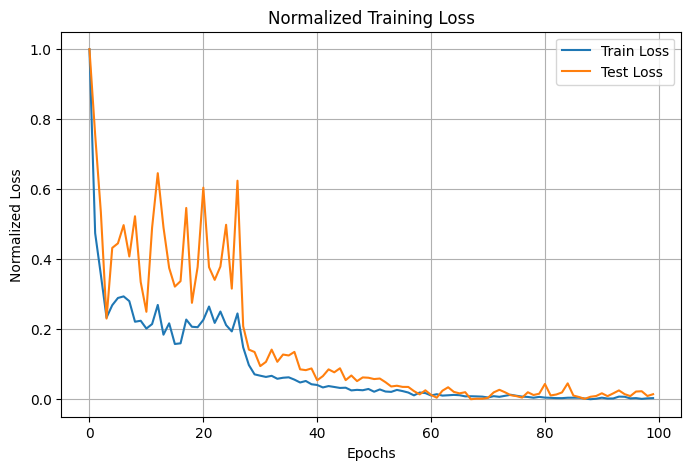

In [98]:
input_len = 4000
output_len = 2

# Instantiate the model
model_8 = tanhModel(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_8.parameters(), lr=learning_rate)

# Initialize the scheduler
from torch.optim import lr_scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Load the data
arr1, arr2 = train_test_model(epoch = 100,model = model_8, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

tanh_model = eval_model(model_8, test_loader, loss_fn, device)

#### Sigmoid

$Sigmoid(x) = \frac{1}{1+exp(-x)}$

In [99]:
class sigmoidModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 128):
        super(sigmoidModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.Sigmoid(),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.Sigmoid(),
            nn.Linear(in_features= hidden_units, out_features= output_size),   
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 0.30719936406612397 | Loss test: 0.16172766964882612 | lr = 0.01
Epoch 10 | Loss train: 0.11800026875734329 | Loss test: 0.13028336502611637 | lr = 0.01
Epoch 20 | Loss train: 0.12045573815703392 | Loss test: 0.11545595130883157 | lr = 0.001
Epoch 30 | Loss train: 0.08732910090684891 | Loss test: 0.09772156924009323 | lr = 0.001
Epoch 40 | Loss train: 0.08370951926708221 | Loss test: 0.09373847674578428 | lr = 0.001
Epoch 50 | Loss train: 0.0824422337114811 | Loss test: 0.09358093584887683 | lr = 0.001
Epoch 60 | Loss train: 0.08103178927302361 | Loss test: 0.09281313396058977 | lr = 0.001
Epoch 70 | Loss train: 0.08029477909207344 | Loss test: 0.09036649647168815 | lr = 0.001
Epoch 80 | Loss train: 0.07878407800197601 | Loss test: 0.09106802241876721 | lr = 0.001
Epoch 90 | Loss train: 0.07742057844996453 | Loss test: 0.09238463477231562 | lr = 0.001
Epoch 100 | Loss train: 0.0766248527765274 | Loss test: 0.09318465390242636 | lr = 0.001


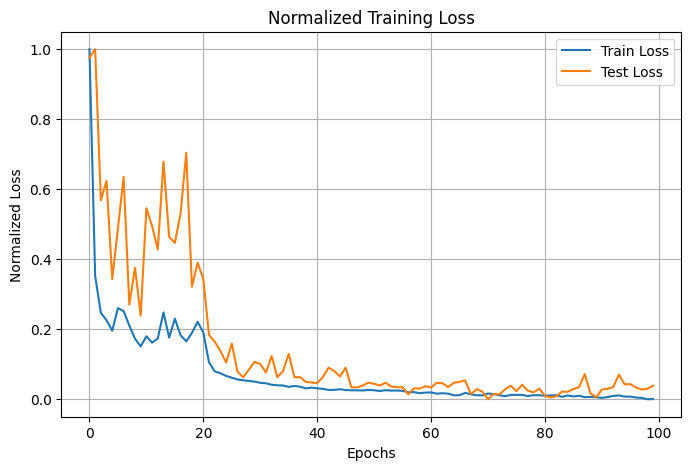

In [101]:
input_len = 4000
output_len = 2

# Instantiate the model
model_9 = sigmoidModel(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_9.parameters(), lr=learning_rate)

# Initialize the scheduler
from torch.optim import lr_scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Load the data
arr1, arr2 = train_test_model(epoch = 100,model = model_9, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

sigmoid_model = eval_model(model_9, test_loader, loss_fn, device)

### Αρχιτεκτονική 3

Μιας και βλέπουμε ότι τα καλύτερα αποτελέσματα τα δίνει το μοντέλο με συνάρτηση ενεργοποίησης LeakyReLU , θα δοκιμάσουμε να βάλουμε άλλο ένα layer για να δούμε πως θα επηρεαστουν τα αποτελέσματα.

In [109]:
class LeakyReLUModel4(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 128):
        super(LeakyReLUModel4, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= output_size)
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 1.9032922359704971 | Loss test: 0.16731470241211355 | lr = 0.01
Epoch 10 | Loss train: 0.134427575096488 | Loss test: 0.048042480542790145 | lr = 0.01
Epoch 20 | Loss train: 0.010350166022777557 | Loss test: 0.008236059598857537 | lr = 0.001
Epoch 30 | Loss train: 0.0060007548090070485 | Loss test: 0.005223666477832012 | lr = 0.001
Epoch 40 | Loss train: 0.003373895666562021 | Loss test: 0.00290954182491987 | lr = 0.001
Epoch 50 | Loss train: 0.002356404065620154 | Loss test: 0.002959123048640322 | lr = 0.001
Epoch 60 | Loss train: 0.0018343236185610293 | Loss test: 0.0015867846959736198 | lr = 0.001
Epoch 70 | Loss train: 0.0005002648514928296 | Loss test: 0.0004633265748452686 | lr = 0.0001
Epoch 80 | Loss train: 0.00030353006842778995 | Loss test: 0.0003048740547910711 | lr = 0.0001
Epoch 90 | Loss train: 0.00023599496902897954 | Loss test: 0.00023244265457833535 | lr = 0.0001
Epoch 100 | Loss train: 0.00023229280416853725 | Loss test: 0.00031953042207533144 | 

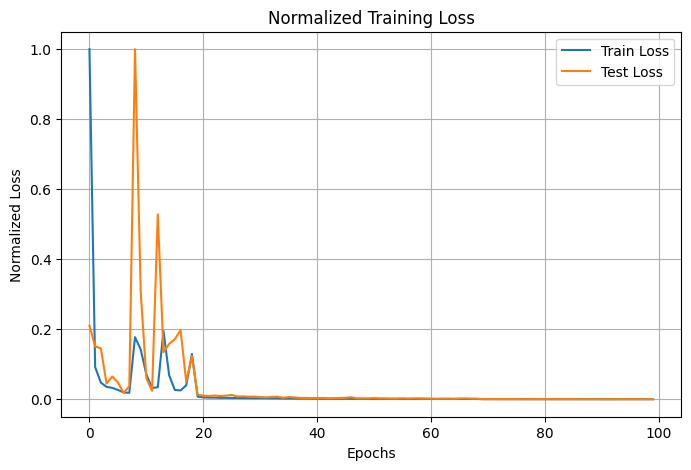

In [110]:
input_len = 4000
output_len = 2

# Instantiate the model
model_10 = LeakyReLUModel4(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_10.parameters(), lr=learning_rate)

# Initialize the scheduler
from torch.optim import lr_scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Load the data
arr1, arr2 = train_test_model(epoch = 100,model = model_10, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

leakyrelu_4 = eval_model(model_10, test_loader, loss_fn, device)

Παρατηρούμε ότι η επίδοση του μοντέλου δεν καλυτέρεψε, άρα δεν χρειάζεται να προσθέσουμε και άλλα layers.

## Results

In [113]:
compare_results = pd.DataFrame([leakyrelu, leakyrelu_4, relu_model, sigmoid_model, tanh_model])
compare_results

,model_name,model_loss
0,LeakyReLUModel,0.000218
1,LeakyReLUModel4,0.000320
2,ReLUModel,0.002269
3,sigmoidModel,0.093185
4,tanhModel,0.110029


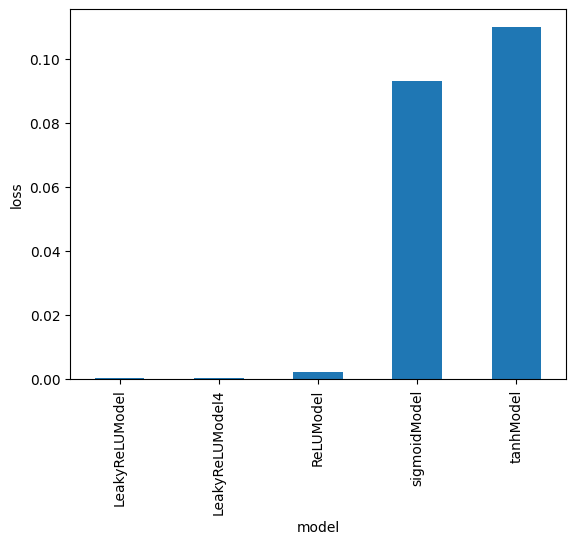

In [114]:
# Visualize our model results
compare_results.set_index("model_name")["model_loss"].plot(kind="bar")
plt.xlabel("model")
plt.ylabel("loss")
plt.show()

***